In [3]:
from datasets import load_dataset, Features, Value
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

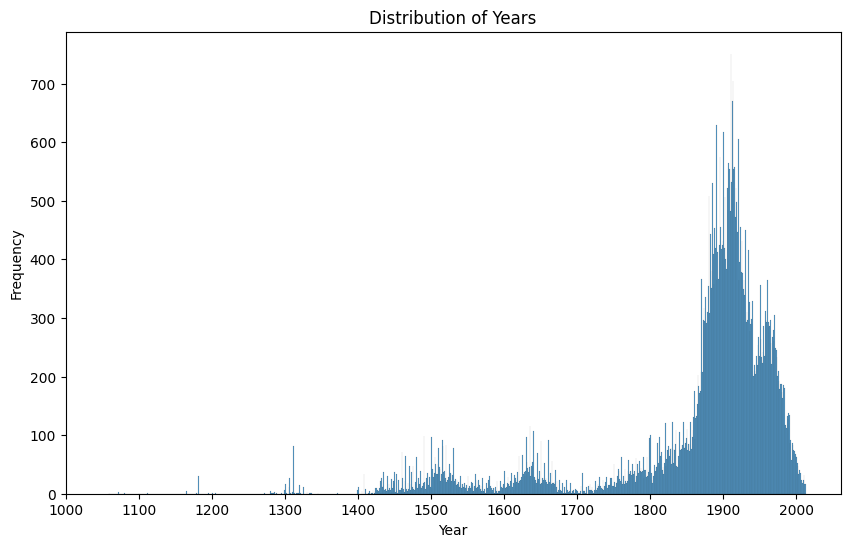

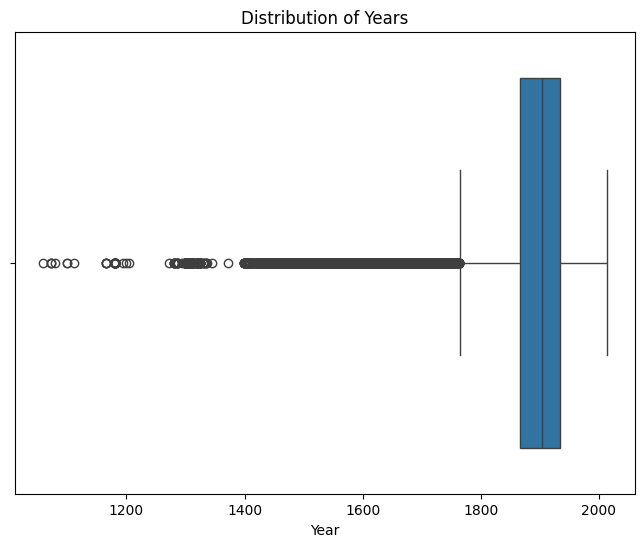

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

full_dataset = load_dataset("MissTiny/WikiArt",cache_dir=r"C:\Users\KL\Desktop\ML")
full_years = np.array(full_dataset['train']['date']).astype(int)

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(full_years, bins=range(int(full_years.min()), int(full_years.max()) + 1), kde=False)
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(range(1000, 2100, 100))  # Adjust step as needed
plt.show()

# Alternatively, a boxplot to visualize range and detect outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=full_years)
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.show()

In [ ]:
Q1 = np.percentile(full_years, 25)
Q3 = np.percentile(full_years, 75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = full_years[(full_years < lower_bound) | (full_years > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 7634


# Cleaned Dataset

In [4]:
cleaned_dataset = load_dataset("MissTiny/WikiArts_contrained",cache_dir=r"C:\Users\KL\Desktop\ML")

In [6]:
small_train = cleaned_dataset['train'].select_columns(['CLIPVisionModelWithProjection_image_embeds', 'date'])
small_test = cleaned_dataset['test'].select_columns(['CLIPVisionModelWithProjection_image_embeds', 'date'])
years = np.array(small_train['date']).astype(int)
print(small_train)
print(small_test)

Dataset({
    features: ['CLIPVisionModelWithProjection_image_embeds', 'date'],
    num_rows: 48091
})
Dataset({
    features: ['CLIPVisionModelWithProjection_image_embeds', 'date'],
    num_rows: 16042
})


# LightGBM

### Encode years (For classification)

In [32]:
min_year_encoded = (min(years) - (min(years) // 100 * 100)) // 10 * 10 + (min(years) // 100 * 100)
years_encoded = min_year_encoded + ((years - min_year_encoded) // 20 * 20)

In [33]:
unique_classes = np.unique(years_encoded)
num_classes = len(unique_classes)

print(f"Unique Classes: {unique_classes}")
print(f"Number of Classes: {num_classes}")

Unique Classes: [1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 2000]
Number of Classes: 11


In [34]:
label_encoder = LabelEncoder()
y_class = label_encoder.fit_transform(years_encoded)

print(f"Encoded Labels: {y_class[0:5]} ...")
print(f"Mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")


Encoded Labels: [5 5 6 3 8] ...
Mapping: {np.int64(1800): 0, np.int64(1820): 1, np.int64(1840): 2, np.int64(1860): 3, np.int64(1880): 4, np.int64(1900): 5, np.int64(1920): 6, np.int64(1940): 7, np.int64(1960): 8, np.int64(1980): 9, np.int64(2000): 10}


### Split data

In [7]:
# Regression
embeddings = np.array(small_train['CLIPVisionModelWithProjection_image_embeds'])
X = np.vstack(embeddings)
y = years
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

In [36]:
# Classification
embeddings = np.array(small_train['CLIPVisionModelWithProjection_image_embeds'])
X = np.vstack(embeddings)
y = y_class

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

### Create LightGBM datasets

In [8]:
import lightgbm as lgb
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

### Use Random Search to Find Best Model Parameters (Optional)

In [13]:
# Define a parameter grid
param_grid = {
    'n_estimators': [100, 300, 1000],
    'num_leaves': [15, 31, 63],
    'max_depth': [8, 12, 16],
    'learning_rate': [0.001, 0.002, 0.005],
    'min_data_in_leaf': [100, 200, 500],
    'lambda_l1': [0.5, 1.0, 2.0],
    'lambda_l2': [0.5, 1.0, 2.0],
    'feature_fraction': [0.6, 0.75, 0.9],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [5, 10, 15]
}

In [14]:
# Initialize a LightGBM classifier
lgb_clf = lgb.LGBMClassifier(
    objective='multiclassova',
    num_class=num_classes,
    metric='auc_mu',
    is_unbalance=True,
    boosting_type='gbdt',
    verbose=-1
)

In [39]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc_ovr',
    cv=3,
    verbose=1,
    random_state=11,
    n_jobs=-1
)

In [ ]:
# Fit the random search model
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)],     
                  callbacks=[lgb.early_stopping(stopping_rounds=100),lgb.log_evaluation(1)])

# Best parameters
print("Best parameters found: ", random_search.best_params_)

### Train the LightGBM Model

In [9]:
# Regression
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.001,
    'num_leaves': 15,
    'max_depth': 6,
    #'lambda_l1': 1.0,
    #'lambda_l2': 0.1,
    #'min_gain_to_split': 0.5,
    #'feature_fraction': 0.8,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'scale_pos_weight': 1,
    #'verbose': -1
}

In [38]:
# Classification
params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'learning_rate': 0.005,
    'num_leaves': 15,
    'max_depth': -1,
    #'lambda_l1': 1.0,
    #'lambda_l2': 1.0,
    #'min_gain_to_split': 0.5,
    #'feature_fraction': 0.8,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'scale_pos_weight': 1,
    #'verbose': -1
}

In [10]:
gbm = lgb.train(
    params,
    train_dataset,
    num_boost_round=10000,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(200)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130560
[LightGBM] [Info] Number of data points in the train set: 38472, number of used features: 512
[LightGBM] [Info] Start training from score 1912.547853
Training until validation scores don't improve for 200 rounds
[200]	train's rmse: 30.1515	valid's rmse: 30.4504
[400]	train's rmse: 26.6341	valid's rmse: 27.0586
[600]	train's rmse: 25.219	valid's rmse: 25.7431
[800]	train's rmse: 24.4747	valid's rmse: 25.0799
[1000]	train's rmse: 23.9988	valid's rmse: 24.6923
[1200]	train's rmse: 23.6435	valid's rmse: 24.4294
[1400]	train's rmse: 23.3493	valid's rmse: 24.2309
[1600]	train's rmse: 23.0884	valid's rmse: 24.0595
[1800]	train's rmse: 22.85	valid's rmse: 23.9122
[2000]	train's rmse: 22.6271	valid's rmse: 23.7763
[2200]	train's rmse: 22.4256	valid's rmse: 23.6605
[2400]	train's rmse: 22.2393	valid's

### Model Evaluation

In [11]:
test_embeddings = np.array(small_test['CLIPVisionModelWithProjection_image_embeds'])
test_years = np.array(small_test['date']).astype(int)
X_test = np.vstack(test_embeddings)
y_test = test_years

Validation Mean Squared Error (MSE): 498.9717
Validation Root Mean Squared Error (RMSE): 22.3377
Validation Mean Absolute Error (MAE): 16.7951


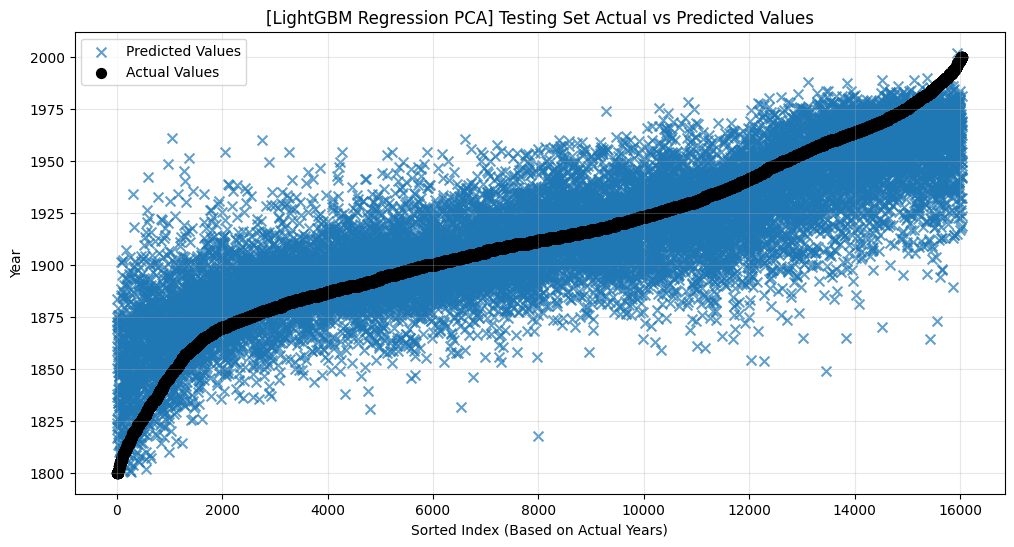

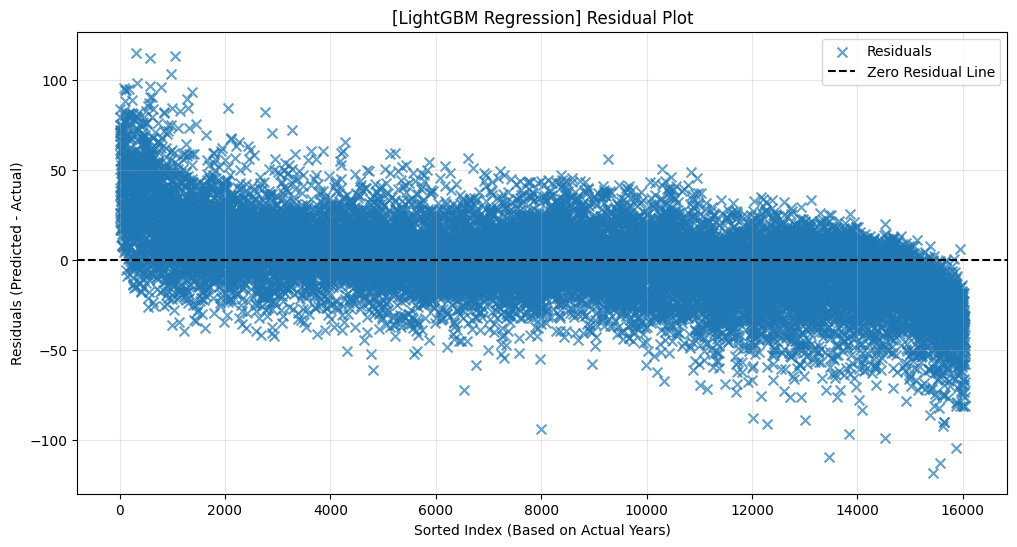

In [12]:
y_pred = gbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
print(f"Validation Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")

# Sort validation data by actual values
sorted_indices = np.argsort(y_test)
y_val_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plot sorted actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted Values", alpha=0.7, s=50, marker='x')
plt.scatter(range(len(y_val_sorted)), y_val_sorted, label="Actual Values", alpha=1, color='black', s=50)
plt.xlabel("Sorted Index (Based on Actual Years)")
plt.ylabel("Year")
plt.title("[LightGBM Regression PCA] Testing Set Actual vs Predicted Values")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Residual Plot
residuals = y_pred - y_test
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals[sorted_indices])), residuals[sorted_indices], alpha=0.7, label="Residuals", s=50, marker='x')
plt.axhline(0, color='black', linestyle='--', linewidth=1.5, label="Zero Residual Line")
plt.xlabel("Sorted Index (Based on Actual Years)")
plt.ylabel("Residuals (Predicted - Actual)")
plt.title("[LightGBM Regression] Residual Plot")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [13]:
# Accuracy for 20-year ranges
def accuracy_conferral(y_test, y_pred, interval = 20):
    count = 0
    total = y_test.shape[0]
    for i in range(total):
        diff = abs(y_test[i]-y_pred[i])
        if diff <= interval:
            count +=1
    return count/total

accuracy_conferral(y_test, y_pred)

0.68732078294477

In [14]:
# Accuracy for 30-year ranges
def accuracy_conferral(y_test, y_pred, interval = 30):
    count = 0
    total = y_test.shape[0]
    for i in range(total):
        diff = abs(y_test[i]-y_pred[i])
        if diff <= interval:
            count +=1
    return count/total

accuracy_conferral(y_test, y_pred)

0.8428500187009101

In [18]:
gbm.save_model("lightgbm_reg_model.txt")